<a href="https://colab.research.google.com/github/head1ton/006_Medical_Analysis/blob/main/isbi_2012/UNet_ISBI_2012.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

from absl import flags
from absl import app
from keras._tf_keras.keras.preprocessing.image  import ImageDataGenerator

# from model import UNET_ISBI_2012
# from loss import binary_loss_object

In [2]:
class UNET_ISBI_2012(keras.Model):
    def __init__(self, num_classes):
        super(UNET_ISBI_2012, self).__init__()

        # Input
        inputs = keras.layers.Input((512, 512, 1))

        # Contracting Part
        conv1 = keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
        conv1 = keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
        assert conv1.shape[1:] == (512, 512, 64)

        pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
        assert pool1.shape[1:] == (256, 256, 64)

        conv2 = keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
        conv2 = keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
        assert conv2.shape[1:] == (256, 256, 128)

        pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
        assert pool2.shape[1:] == (128, 128, 128)

        conv3 = keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
        conv3 = keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
        assert conv3.shape[1:] == (128, 128, 256)

        pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
        assert pool3.shape[1:] == (64, 64, 256)

        conv4 = keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
        conv4 = keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
        drop4 = keras.layers.Dropout(0.5)(conv4)
        assert drop4.shape[1:] == (64, 64, 512)

        pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)
        assert pool4.shape[1:] == (32, 32, 512)

        conv5 = keras.layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
        conv5 = keras.layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
        assert conv5.shape[1:] == (32, 32, 1024)

        drop5 = keras.layers.Dropout(0.5)(conv5)

        # Expansive Part
        up6 = keras.layers.Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(keras.layers.UpSampling2D(size=(2, 2))(drop5))
        assert up6.shape[1:] == (64, 64, 512)

        merge6 = keras.layers.concatenate([drop4, up6], axis=3)
        assert merge6.shape[1:] == (64, 64, 1024)

        conv6 = keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
        conv6 = keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
        assert conv6.shape[1:] == (64, 64, 512)

        up7 = keras.layers.Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(keras.layers.UpSampling2D(size=(2, 2))(conv6))
        assert up7.shape[1:] == (128, 128, 256)

        merge7 = keras.layers.concatenate([conv3, up7], axis=3)
        assert merge7.shape[1:] == (128, 128, 512)

        conv7 = keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
        conv7 = keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
        assert conv7.shape[1:] == (128, 128, 256)

        up8 = keras.layers.Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(keras.layers.UpSampling2D(size=(2, 2))(conv7))
        assert up8.shape[1:] == (256, 256, 128)

        merge8 = keras.layers.concatenate([conv2, up8], axis=3)
        assert merge8.shape[1:] == (256, 256, 256)

        conv8 = keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
        conv8 = keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
        assert conv8.shape[1:] == (256, 256, 128)

        up9 = keras.layers.Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(keras.layers.UpSampling2D(size=(2, 2))(conv8))
        assert up9.shape[1:] == (512, 512, 64)

        merge9 = keras.layers.concatenate([conv1, up9], axis=3)
        assert merge9.shape[1:] == (512, 512, 128)

        conv9 = keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
        conv9 = keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
        assert conv9.shape[1:] == (512, 512, 64)

        conv9 = keras.layers.Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
        assert conv9.shape[1:] == (512, 512, 2)

        conv10 = keras.layers.Conv2D(num_classes, 1, activation='sigmoid')(conv9)
        assert conv10.shape[1:] == (512, 512, num_classes)

        # Model
        model = keras.Model(inputs=inputs, outputs=conv10)

        self.model = model

        self.model.summary()

    def call(self, x):
        return self.model(x)

In [3]:
binary_loss_object = keras.losses.BinaryCrossentropy(from_logits=False)

sparse_categorical_cross_entropy_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [4]:
!unzip isbi_2012_dataset.zip -d ./isbi_2012_dataset

Archive:  isbi_2012_dataset.zip
replace ./isbi_2012_dataset/data_unzip_preprocessing.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./isbi_2012_dataset/data_unzip_preprocessing.py  
  inflating: ./isbi_2012_dataset/__MACOSX/._data_unzip_preprocessing.py  
  inflating: ./isbi_2012_dataset/__MACOSX/._datasets  
  inflating: ./isbi_2012_dataset/__MACOSX/datasets/._test_images  
  inflating: ./isbi_2012_dataset/__MACOSX/datasets/._train_images  
  inflating: ./isbi_2012_dataset/__MACOSX/datasets/._train_labels  
  inflating: ./isbi_2012_dataset/datasets/test_images/8.png  
  inflating: ./isbi_2012_dataset/__MACOSX/datasets/test_images/._8.png  
  inflating: ./isbi_2012_dataset/datasets/test_images/9.png  
  inflating: ./isbi_2012_dataset/__MACOSX/datasets/test_images/._9.png  
  inflating: ./isbi_2012_dataset/datasets/test_images/14.png  
  inflating: ./isbi_2012_dataset/__MACOSX/datasets/test_images/._14.png  
  inflating: ./isbi_2012_dataset/datasets/test_images/28.png  
  infl

In [5]:
# tf.random.set_seed(4000)

# flags.DEFINE_string('checkpoint_path', default='saved_model_isbi_2012/unet_model.h5', help='Path to save the model checkpoint')
# flags.DEFINE_string('tensorboard_log_path', default='tensorboard_log_isbi_2012', help='Path to save the tensorboard logs')
# flags.DEFINE_integer('num_epochs', default=5, help='Number of epochs to train the model')
# flags.DEFINE_integer('steps_per_epoch', default=2000, help='Number of steps per epoch')
# flags.DEFINE_integer('num_classes', default=1, help='Number of classes in the dataset')

# FLAGS = flags.FLAGS

# batch_size = 2
# learning_rate = 0.0001

In [21]:
tf.random.set_seed(4000)

checkpoint_path = 'saved_model_isbi_2012/unet_model.h5'
tensorboard_log_path = 'tensorboard_log_isbi_2012'
num_epochs = 5
steps_per_epoch = 2000
num_classes = 1

batch_size = 2
learning_rate = 0.0001

In [22]:
def normalize_isbi_2012(image_gen, mask_gen):
    input_images = image_gen / 255
    mask_labels = mask_gen / 255

    mask_labels[mask_labels > 0.5] = 1
    mask_labels[mask_labels <= 0.5] = 0

    return input_images, mask_labels

In [23]:
def make_train_generator(batch_size, aug_dict):
    """
    Create a training data generator with data augmentation.

    Args:
        batch_size (int): Size of the batches of data.
        aug_dict (dict): Dictionary containing augmentation parameters.

    Returns:
        train_generator: A generator that yields augmented training data.
    """
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_directory(
        directory='./isbi_2012_dataset/datasets',
        classes=['train_images'],
        class_mode=None,
        target_size=(512, 512),
        batch_size=batch_size,
        color_mode='grayscale',
        seed=1
    )

    mask_generator = mask_datagen.flow_from_directory(
        directory='./isbi_2012_dataset/datasets',
        classes=['train_labels'],
        class_mode=None,
        target_size=(512, 512),
        batch_size=batch_size,
        color_mode='grayscale',
        seed=1
    )

    # Assuming you have a directory structure for your dataset
    train_generator = zip(image_generator, mask_generator)

    for (image_gen, mask_gen) in train_generator:
        batch_images, batch_labels = normalize_isbi_2012(image_gen, mask_gen)

        yield batch_images, batch_labels

In [24]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [25]:
def create_mask(pred_mask):
    pred_mask = np.where(pred_mask > 0.5, 1, 0)

    return pred_mask[0]

In [26]:
def show_predictions(model, sample_image, sample_mask):
    display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [27]:
def display_and_save(display_list, epoch):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.savefig(f'Epoch {epoch}.jpg')

In [28]:
def save_predictions(epoch, model, sample_image, sample_mask):
    display_and_save([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))], epoch)

In [29]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, unet_model, sample_image, sample_mask):
        super(CustomCallback, self).__init__()
        self.unet_model = unet_model
        self.sample_image = sample_image
        self.sample_mask = sample_mask

    def on_epoch_end(self, epoch, logs=None):
        save_predictions(epoch + 1, self.unet_model, self.sample_image, self.sample_mask)
        print(f'\nEpoch {epoch + 1} ended. Predictions saved!')

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


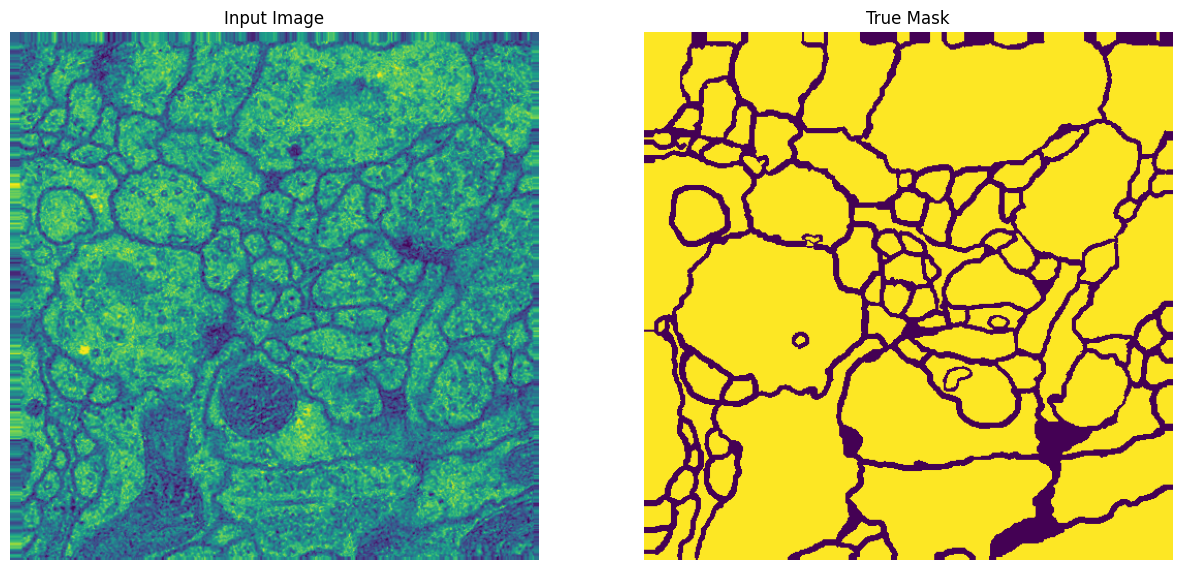

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 256)  │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 512)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 1024)   │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d        

 Total params: 31,031,685 (118.38 MB)

 Trainable params: 31,031,685 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


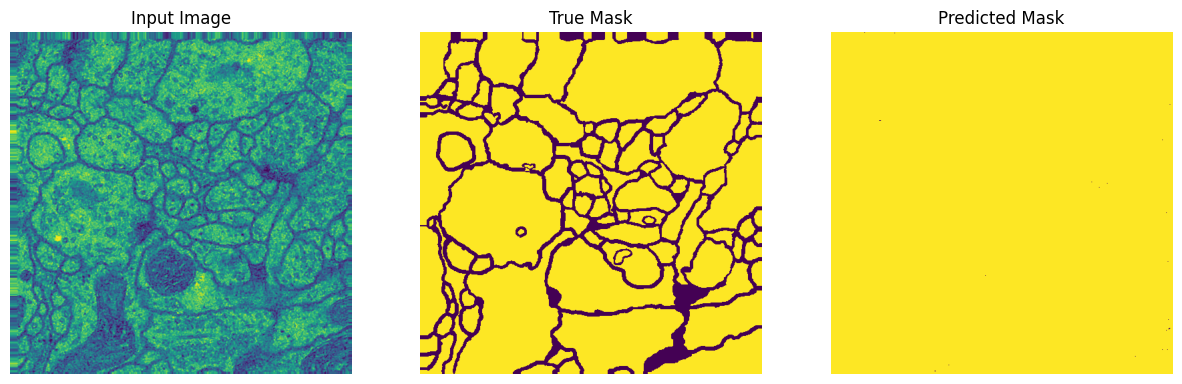

Epoch 1/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.8951 - loss: 0.2768
Epoch 1: loss improved from inf to 0.23412, saving model to saved_model_isbi_2012/unet_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Epoch 1 ended. Predictions saved!
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1165s 555ms/step - accuracy: 0.8952 - loss: 0.2768
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.9535 - loss: 0.1803
Epoch 2: loss improved from 0.23412 to 0.16995, saving model to saved_model_isbi_2012/unet_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step

Epoch 2 ended. Predictions saved!
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1113s 557ms/step - accuracy: 0.9535 - loss: 0.1803
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.9696 - loss: 0.1462
Epoch 3: loss improved from 0.16995 to 0.14050, saving model to saved_model_isbi_2012/unet_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step

Epoch 3 ended. Predictions saved!
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1112s 556ms/step - accuracy: 0.9696 - loss: 0.1462
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.9757 - loss: 0.1256
Epoch 4: loss improved from 0.14050 to 0.12149, saving model to saved_model_isbi_2012/unet_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step

Epoch 4 ended. Predictions saved!
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1111s 556ms/step - accuracy: 0.9757 - loss: 0.1256
Epoch 5/5
1497/2000 ━━━━━━━━━━━━━━━━━━━━ 4:37 552ms/step - accuracy: 0.9786 - loss: 0.1109

In [ ]:
# Argumentation
aug_dict = dict(rotation_range=0.2,
                width_shift_range=0.05,
                height_shift_range=0.05,
                shear_range=0.05,
                zoom_range=0.05,
                horizontal_flip=True,
                fill_mode='nearest')

train_generator = make_train_generator(batch_size, aug_dict)

# sample_image = None
# sample_mask = None

for i, batch_data in enumerate(train_generator):
    # if i >= 2:
    #     break
    batch_image, batch_mask = batch_data[0], batch_data[1]
    sample_image, sample_mask = batch_image[0], batch_mask[0]

    display([sample_image, sample_mask])

    unet_model = UNET_ISBI_2012(num_classes)

    show_predictions(unet_model, sample_image, sample_mask)

    optimizer = keras.optimizers.Adam(learning_rate)

    if not os.path.exists(checkpoint_path.split('/')[0]):
        os.mkdir(checkpoint_path.split('/')[0])

    if os.path.isfile(checkpoint_path):
        unet_model.load_weights(checkpoint_path)
        print(f'{checkpoint_path} checkpoint is restored!')

    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_best_only=True)
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=tensorboard_log_path)
    custom_callback = CustomCallback(unet_model, sample_image, sample_mask)

    unet_model.compile(optimizer=optimizer, loss=binary_loss_object, metrics=['accuracy'])

    unet_model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=num_epochs,
                    callbacks=[model_checkpoint_callback, tensorboard_callback, custom_callback]
                    )